In [37]:
from qick import *
%pylab inline

import time

from scipy.signal import welch
from numpy.fft import fftshift

from scipy.signal import spectrogram
from matplotlib import colors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/Daniel/qick/.qick_venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['psd']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [38]:
# Pyro to communicate with board
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [39]:
GEN_CH = 1
RO_CH = 1
FREQ = 500 # MHz

In [40]:
# clearing the DDR4 buffer - optional, but might be useful for debugging
t = time.time()
soc.clear_ddr4()
print(time.time() - t)

4.655194044113159


In [41]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        style = self.cfg["pulse_style"]

        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"], sel="input")

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "arb":
            idata, qdata = [], []
            for i in range(96):
                # x_vals = np.linspace(0, 2 * np.pi, i * 10 + 100)
                x_vals = np.linspace(0, 2 * np.pi, 20)
                sinusoid = 10000 * np.sin(x_vals)
                idata.extend(sinusoid)
                qdata.extend(sinusoid)
            self.add_envelope(ch=res_ch, name="measure", idata=idata, qdata=qdata)
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="measure", outsel="input")
        
        self.synci(100)  # give processor some time to configure pulses
        self.trigger(ddr4=True, mr=True, adc_trig_offset=self.cfg["adc_trig_offset"])
        self.synci(100)  # give the buffers a little time
        
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [42]:
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":500, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":10000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": FREQ, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":10
        # Try varying soft_avgs from 1 to 200 averages

       }

prog =LoopbackProgram(soccfg, config)
prog.config_all(soc)

n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples

# Arm the buffers
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)
soc.arm_mr(ch=RO_CH)

# Run the program
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'sample number [ADC ticks]')

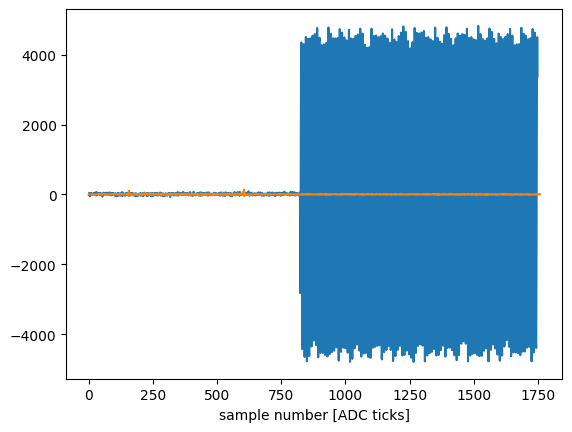

In [43]:
# zoom in and see the up-mixed image tone
iq_mr = soc.get_mr()
iq_ddr4 = soc.get_ddr4(10)
# plt.plot(iq_mr[850:950,0])
plt.plot(iq_mr[:1750,0])
plt.plot(iq_ddr4[:,0])
# plt.plot(iq_mr[2000:2100,1],label="Q")
plt.xlabel("sample number [ADC ticks]")

Frequency: 501.12 MHz


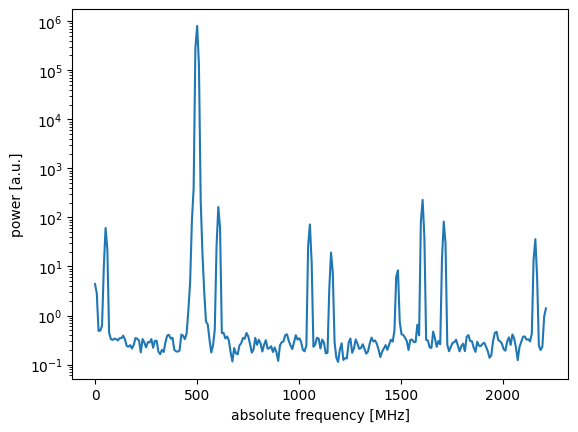

In [44]:
complex_iq = iq_mr.dot([1,1j])

fs_adc = soccfg['readouts'][RO_CH]['fs']

fft_freqs, psd = welch(iq_mr[850:4000,0], fs_adc, return_onesided=True, detrend=False, nperseg=512)
plt.semilogy(fft_freqs, psd)
plt.xlabel("absolute frequency [MHz]")
plt.ylabel("power [a.u.]");
print("Frequency:", fft_freqs[argmax(psd)], "MHz")